<a href="https://colab.research.google.com/github/saad-the-noob/Skill_Morph_Assignment/blob/main/Code_for_Heart_disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**


In [ ]:
!pip install xgboost lightgbm catboost lime -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import shap
import xgboost as xgb
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
                             accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score,
                             roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
                            )
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from lime import lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


# Dataset & font size for figure


In [ ]:
# Set font size and family for the entire figure
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'

In [ ]:
# import the dataset
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_csv(io.BytesIO(uploaded['Heart_disease_cleveland.csv']))

Saving Heart_disease_cleveland.csv to Heart_disease_cleveland.csv


In [ ]:
# Basic exploration
print("Dataset Shape:", data.shape)
print("\n\nFirst 5 rows:")
print(data.head())

print("\n\nDataset Info:")
print(data.info())

print("\n\nBasic Statistics:(For numerical dtypes)")
print(data.describe())

print("\n\nCheck for missing values:")
print(data.isnull().sum())

print("\n\nTarget variable distribution:")
print(data['target'].value_counts())

Dataset Shape: (303, 14)


First 5 rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   0       145   233    1        2      150      0      2.3      2   
1   67    1   3       160   286    0        2      108      1      1.5      1   
2   67    1   3       120   229    0        2      129      1      2.6      1   
3   37    1   2       130   250    0        0      187      0      3.5      2   
4   41    0   1       130   204    0        2      172      0      1.4      0   

   ca  thal  target  
0   0     2       0  
1   3     1       1  
2   2     3       1  
3   0     1       0  
4   0     1       0  


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-n

# Feature selection

Top features by correlation:
thal        0.515894
ca          0.460033
exang       0.431894
oldpeak     0.424510
thalach     0.417167
cp          0.414446
slope       0.339213
sex         0.276816
age         0.223120
restecg     0.169202
trestbps    0.150825
chol        0.085164
fbs         0.025264
Name: target, dtype: float64


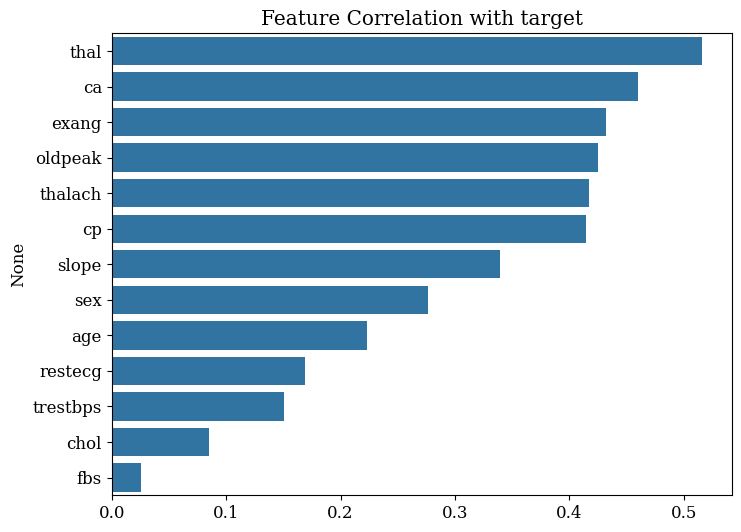

In [ ]:
# Correlation with the target
corr_with_target = data.corr()['target'].drop(['target']).abs().sort_values(ascending=False)  #Took abs() because correlation can be negative

print("Top features by correlation:")
print(corr_with_target)

# visualize
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title("Feature Correlation with target")
plt.show()

Top features by Mutual Information:
cp          0.163149
thal        0.159211
exang       0.137215
ca          0.099974
restecg     0.092808
oldpeak     0.090926
slope       0.090224
chol        0.083756
sex         0.073093
thalach     0.071026
fbs         0.029855
age         0.011350
trestbps    0.000000
dtype: float64


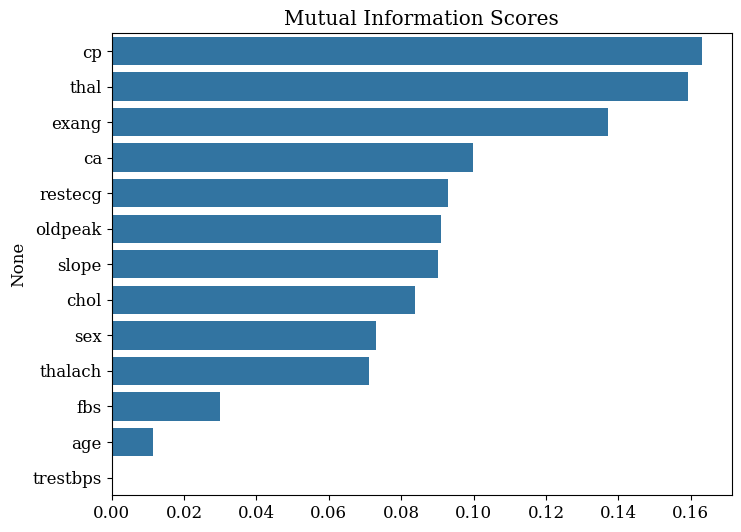

In [ ]:
# MI score for target
x = data.drop(['target'], axis=1)
y = data['target']
# Compute MI scores
mi_scores = mutual_info_classif(x, y, random_state=20)

# Store results in a Series for easy sorting
mi_series = pd.Series(mi_scores, index=x.columns).sort_values(ascending=False)

print("Top features by Mutual Information:")
print(mi_series)


# Optional: visualize
plt.figure(figsize=(8, 6))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Mutual Information Scores")
plt.show()

In [ ]:
# Combine rank
rank_corr = corr_with_target.sort_values(ascending=False).rank(ascending=False)
rank_mi = mi_series.rank(ascending=False)

combined_rank = (rank_corr + rank_mi) / 2

# Sort by combined rank
final_priority = combined_rank.sort_values()

print("Top features (combined correlation + MI):")
print(final_priority.head(6))

Top features (combined correlation + MI):
thal       1.5
ca         3.0
exang      3.0
cp         3.5
oldpeak    5.0
slope      7.0
dtype: float64


# Train & Test

In [ ]:
# Separate input (X) and output (y)
x = data.drop(['target','trestbps','age','fbs','chol','sex','restecg','thalach'], axis=1)
y = data['target']

# Split: 80% for training, 20% for testing
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,    # 20% for test
    random_state=20   # Same result every time
)

# Standard Scaler

In [ ]:
# Create scaler
scaler = StandardScaler()

# Learn from training data and scale it
x_train_scaled = scaler.fit_transform(x_train)

# Scale test data
x_test_scaled = scaler.transform(x_test)

# Models

In [ ]:
# 1. Train Decision Tree Classifier
dt_model = DecisionTreeClassifier( max_depth=5,random_state=42)
dt_model.fit(x_train_scaled, y_train)

# 2. Predict on Test Set
y_pred_dt = dt_model.predict(x_test_scaled)

# 3. Evaluation Metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall_dt = recall_score(y_test, y_pred_dt, average='weighted', zero_division=0)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted', zero_division=0)

print(f"Accuracy:  {accuracy_dt:.5f}")
print(f"Precision: {precision_dt:.5f}")
print(f"Recall:    {recall_dt:.5f}")
print(f"F1 Score:  {f1_dt:.5f}")


Accuracy:  0.80328
Precision: 0.81256
Recall:    0.80328
F1 Score:  0.79967


In [ ]:
# 1. Train KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=35)
knn_model.fit(x_train_scaled, y_train)

# 2. Predict on Test Set
y_pred_knn = knn_model.predict(x_test_scaled)

# 3. Evaluation Metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)

print(f"Accuracy:  {accuracy_knn:.5f}")
print(f"Precision: {precision_knn:.5f}")
print(f"Recall:    {recall_knn:.5f}")
print(f"F1 Score:  {f1_knn:.5f}")


Accuracy:  0.81967
Precision: 0.82137
Recall:    0.81967
F1 Score:  0.81849


In [ ]:
# 1. Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=8, random_state=42)
rf_model.fit(x_train_scaled, y_train)

# 2. Predict on Test Set
y_pred_rf = rf_model.predict(x_test_scaled)

# 3. Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)


print(f"Accuracy:  {accuracy_rf:.5f}")
print(f"Precision: {precision_rf:.5f}")
print(f"Recall:    {recall_rf:.5f}")
print(f"F1 Score:  {f1_rf:.5f}")

Accuracy:  0.78689
Precision: 0.79204
Recall:    0.78689
F1 Score:  0.78394


In [ ]:
# 1. Train Support Vector Machine (SVM)
svm = SVC(kernel='rbf', random_state=42)
svm.fit(x_train_scaled, y_train)

# 2. Predict on Test Set
y_pred_svm = svm.predict(x_test_scaled)

# 3. Evaluation Metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)



print(f"Accuracy:  {accuracy_svm:.5f}")
print(f"Precision: {precision_svm:.5f}")
print(f"Recall:    {recall_svm:.5f}")
print(f"F1 Score:  {f1_svm:.5f}")

Accuracy:  0.80328
Precision: 0.80328
Recall:    0.80328
F1 Score:  0.80328


In [ ]:
# 1. Train Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(x_train_scaled, y_train)

# 2. Predict on Test Set
y_pred_lr = lr.predict(x_test_scaled)


# 3. Evaluation Metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted', zero_division=0)


print(f"Accuracy:  {accuracy_lr:.5f}")
print(f"Precision: {precision_lr:.5f}")
print(f"Recall:    {recall_lr:.5f}")
print(f"F1 Score:  {f1_lr:.5f}")


Accuracy:  0.85246
Precision: 0.86043
Recall:    0.85246
F1 Score:  0.85042


In [ ]:
# XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=10,         # number of trees
    learning_rate=0.05,      # step size shrinkage
    max_depth=5,             # max depth of each tree
    subsample=0.8,           # fraction of samples used per tree
    colsample_bytree=0.8,    # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the model
xgb_model.fit(x_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(x_test_scaled)

# 3. Evaluation Metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)


print(f"Accuracy:  {accuracy_xgb:.5f}")
print(f"Precision: {precision_xgb:.5f}")
print(f"Recall:    {recall_xgb:.5f}")
print(f"F1 Score:  {f1_xgb:.5f}")

Accuracy:  0.78689
Precision: 0.82546
Recall:    0.78689
F1 Score:  0.77606


In [ ]:
# LightGBM model
lgb_model = lgb.LGBMClassifier(
    n_estimators=35,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=-1,           # Suppress output
    force_col_wise=True   # Remove warnings
)

# Fit the model
lgb_model.fit(x_train_scaled, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(x_test_scaled)

# 3. Evaluation Metrics
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb, average='weighted', zero_division=0)
recall_lgb = recall_score(y_test, y_pred_lgb, average='weighted', zero_division=0)
f1_lgb = f1_score(y_test, y_pred_lgb, average='weighted', zero_division=0)


print(f"Accuracy:  {accuracy_lgb:.5f}")
print(f"Precision: {precision_lgb:.5f}")
print(f"Recall:    {recall_lgb:.5f}")
print(f"F1 Score:  {f1_lgb:.5f}")

Accuracy:  0.90164
Precision: 0.90777
Recall:    0.90164
F1 Score:  0.90067


In [ ]:
#  CatBoost model
cat_model = CatBoostClassifier(
    iterations=30,        # Number of trees
    learning_rate=0.2,
    depth=5,              # Tree depth
    random_state=42,
    verbose=0             # Suppress output
)

# Fit the model
cat_model.fit(x_train_scaled, y_train)

# Make predictions
y_pred_cat = cat_model.predict(x_test_scaled)

# 3. Evaluation Metrics
accuracy_cat = accuracy_score(y_test, y_pred_cat)
precision_cat = precision_score(y_test, y_pred_cat, average='weighted', zero_division=0)
recall_cat = recall_score(y_test, y_pred_cat, average='weighted', zero_division=0)
f1_cat = f1_score(y_test, y_pred_cat, average='weighted', zero_division=0)


print(f"Accuracy:  {accuracy_cat:.5f} ")
print(f"Precision: {precision_cat:.5f}")
print(f"Recall:    {recall_cat:.5f}")
print(f"F1 Score:  {f1_cat:.5f}")

Accuracy:  0.88525 
Precision: 0.88535
Recall:    0.88525
F1 Score:  0.88506


#Model Comparison & Metrices





In [ ]:
# Create comparison DataFrame
results = pd.DataFrame({
    'Model': ['Decision Tree','KNN','Random Forest','Support Vector Machine (SVM)','Logistic Regression','XGBoost', 'LightGBM', 'CatBoost'],
    'Accuracy': [accuracy_dt,accuracy_knn,accuracy_rf,accuracy_svm,accuracy_lr,accuracy_xgb,accuracy_lgb,accuracy_cat],
    'Precision': [precision_dt,precision_knn,precision_rf,precision_svm,precision_lr,precision_xgb,precision_lgb,precision_cat],
    'Recall': [recall_dt,recall_knn,recall_rf,recall_svm,recall_lr,recall_xgb,recall_lgb,recall_cat],
    'F1 Score': [f1_dt,f1_knn,f1_rf,f1_svm,f1_lr,f1_xgb,f1_lgb,f1_cat]
    }).sort_values('Accuracy', ascending=False).reset_index(drop=True)



print("                           MODEL COMPARISON")
display(results)

# Find best model
best_model = results.iloc[0]['Model']
best_acc = results.iloc[0]['Accuracy']
print(f"The best model is {best_model} with an accuracy of {best_acc*100:.2f}% ")




                           MODEL COMPARISON


,Model,Accuracy,Precision,Recall,F1 Score
0,LightGBM,0.901639,0.907768,0.901639,0.900667
1,CatBoost,0.885246,0.885353,0.885246,0.885059
2,Logistic Regression,0.852459,0.860431,0.852459,0.850422
3,KNN,0.819672,0.821366,0.819672,0.818489
4,Decision Tree,0.803279,0.812564,0.803279,0.799672
5,Support Vector Machine (SVM),0.803279,0.803279,0.803279,0.803279
6,Random Forest,0.786885,0.792043,0.786885,0.783942
7,XGBoost,0.786885,0.825458,0.786885,0.776060


The best model is LightGBM with an accuracy of 90.16% 


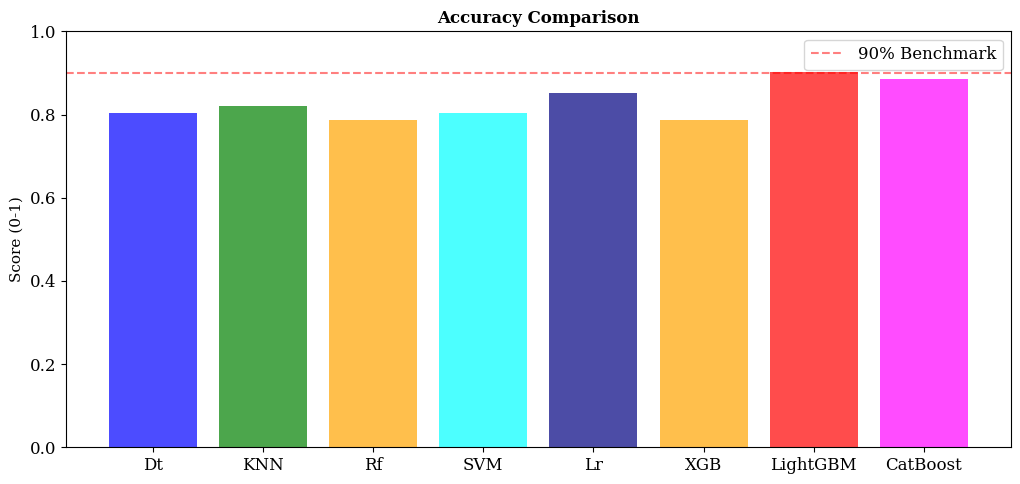

In [ ]:
# Detailed metrics visualization
plt.figure(figsize=(20, 5))

# Subplot 1: Accuracy comparison
plt.subplot(1, 2, 1)
metrics = ['Dt','KNN','Rf','SVM','Lr','XGB', 'LightGBM', 'CatBoost']
values = [accuracy_dt,accuracy_knn,accuracy_rf,accuracy_svm,accuracy_lr,accuracy_xgb,accuracy_lgb,accuracy_cat]
colors = ['blue', 'green', 'orange', 'cyan','navy','orange','red','magenta']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.title('Accuracy Comparison', fontweight='bold', fontsize=12)
plt.ylabel('Score (0-1)', fontsize=11)

# Add benchmark line
plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% Benchmark')
plt.legend()

plt.tight_layout()
plt.show()

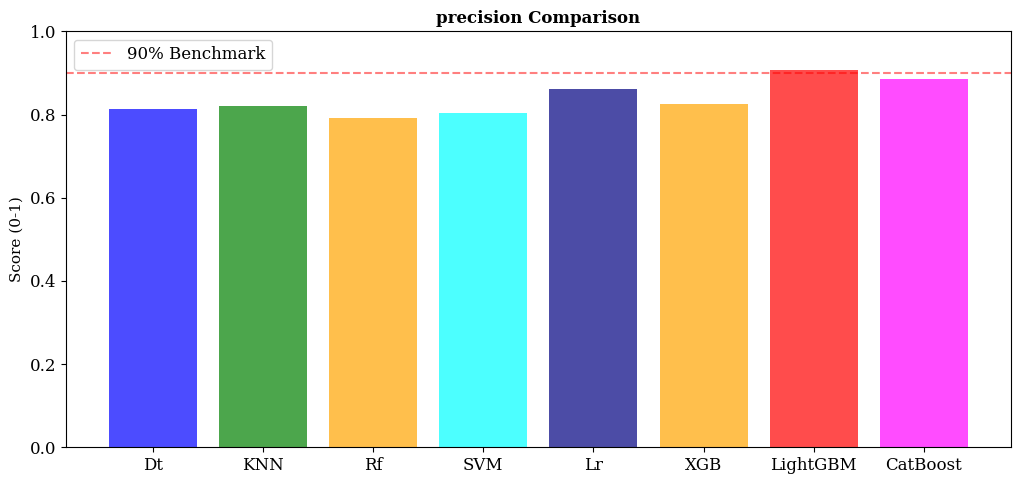

In [ ]:
# Detailed metrics visualization
plt.figure(figsize=(20, 5))

# Subplot 1: precision comparison
plt.subplot(1, 2, 1)
metrics = ['Dt','KNN','Rf','SVM','Lr','XGB', 'LightGBM', 'CatBoost']
values = [precision_dt,precision_knn,precision_rf,precision_svm,precision_lr,precision_xgb,precision_lgb,precision_cat]
colors = ['blue', 'green', 'orange', 'cyan','navy','orange','red','magenta']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.title('precision Comparison', fontweight='bold', fontsize=12)
plt.ylabel('Score (0-1)', fontsize=11)

# Add benchmark line
plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% Benchmark')
plt.legend()

plt.tight_layout()
plt.show()

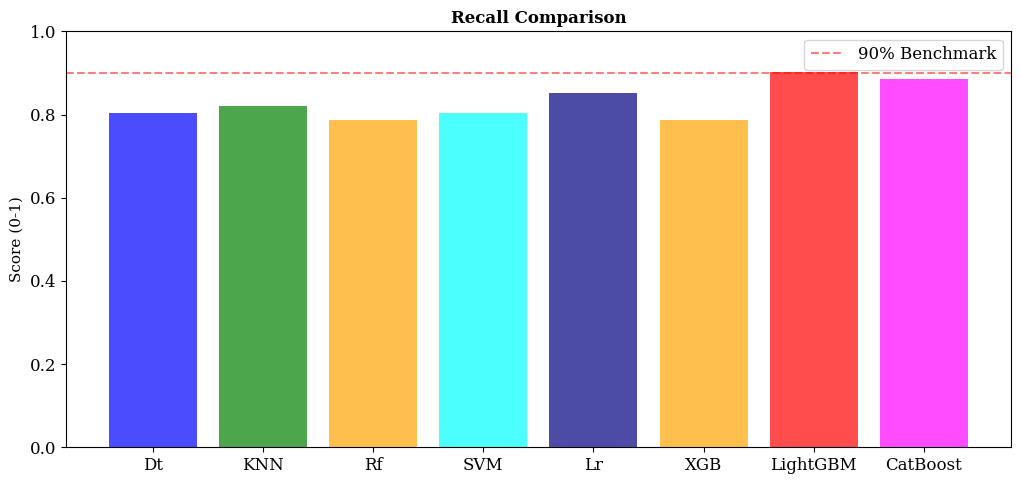

In [ ]:
# Detailed metrics visualization for Recall
plt.figure(figsize=(20, 5))

# Subplot 1: recall comparison
plt.subplot(1, 2, 1)
metrics = ['Dt', 'KNN', 'Rf', 'SVM', 'Lr', 'XGB', 'LightGBM', 'CatBoost']
values = [recall_dt, recall_knn, recall_rf, recall_svm, recall_lr, recall_xgb, recall_lgb, recall_cat]
colors = ['blue', 'green', 'orange', 'cyan', 'navy', 'orange', 'red', 'magenta']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.title('Recall Comparison', fontweight='bold', fontsize=12)
plt.ylabel('Score (0-1)', fontsize=11)

# Add benchmark line
plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% Benchmark')
plt.legend()

plt.tight_layout()
plt.show()

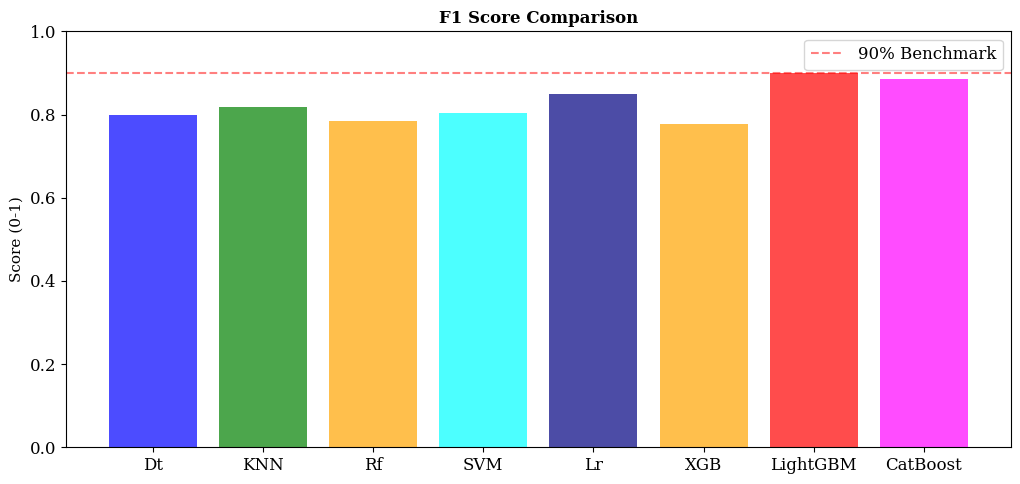

In [ ]:
# Detailed metrics visualization for F1-Score
plt.figure(figsize=(20, 5))

# Subplot 1: F1 comparison
plt.subplot(1, 2, 1)
metrics = ['Dt', 'KNN', 'Rf', 'SVM', 'Lr', 'XGB', 'LightGBM', 'CatBoost']
values = [f1_dt, f1_knn, f1_rf, f1_svm, f1_lr, f1_xgb, f1_lgb, f1_cat]
colors = ['blue', 'green', 'orange', 'cyan', 'navy', 'orange', 'red', 'magenta']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.title('F1 Score Comparison', fontweight='bold', fontsize=12)
plt.ylabel('Score (0-1)', fontsize=11)

# Add benchmark line
plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% Benchmark')
plt.legend()

plt.tight_layout()
plt.show()

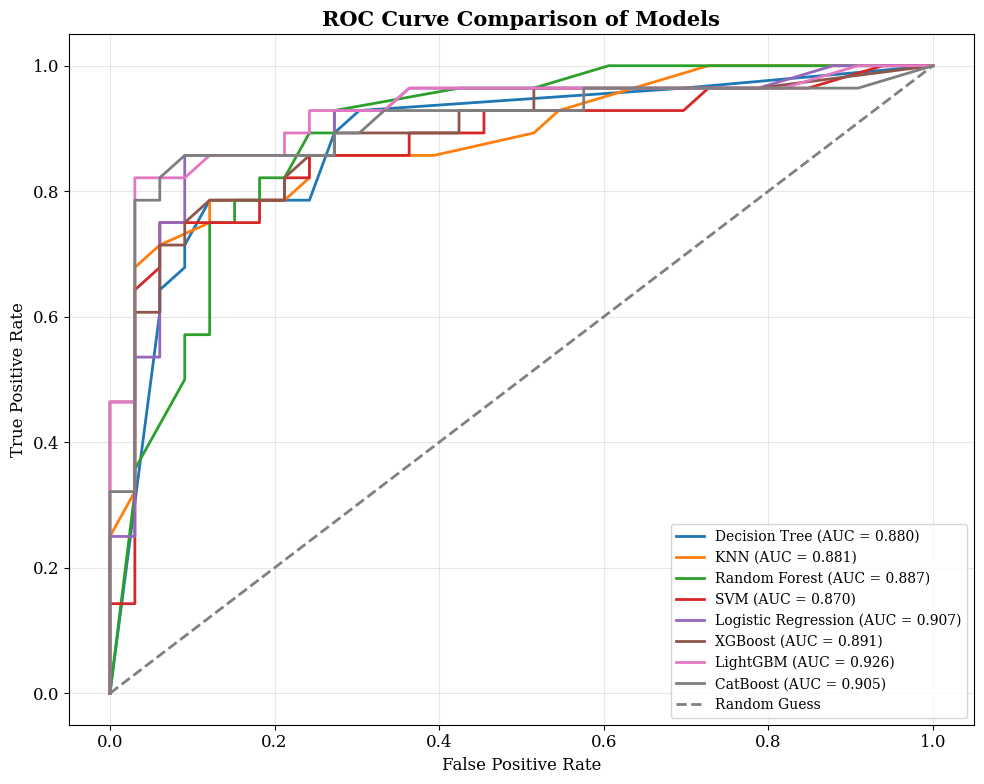

In [ ]:
# Plot ROC curve for each model
y_pred_proba_knn = knn_model.predict_proba(x_test_scaled)[:, 1]
y_pred_proba_dt = dt_model.predict_proba(x_test_scaled)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(x_test_scaled)[:, 1]
y_pred_proba_svm = svm.decision_function(x_test_scaled)      # SVM has expection method
y_pred_proba_lr = lr.predict_proba(x_test_scaled)[:, 1]
y_pred_proba_xgb = xgb_model.predict_proba(x_test_scaled)[:, 1]
y_pred_proba_lgb = lgb_model.predict_proba(x_test_scaled)[:, 1]
y_pred_proba_cat = cat_model.predict_proba(x_test_scaled)[:, 1]

model_probs = {
    'Decision Tree': y_pred_proba_dt,
    'KNN': y_pred_proba_knn,
    'Random Forest': y_pred_proba_rf,
    'SVM': y_pred_proba_svm,
    'Logistic Regression': y_pred_proba_lr,
    'XGBoost': y_pred_proba_xgb,
    'LightGBM': y_pred_proba_lgb,
    'CatBoost': y_pred_proba_cat
      }

plt.figure(figsize=(10, 8))


for model_name, probs in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')

# Plot styling
plt.title('ROC Curve Comparison of Models', fontsize=15, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

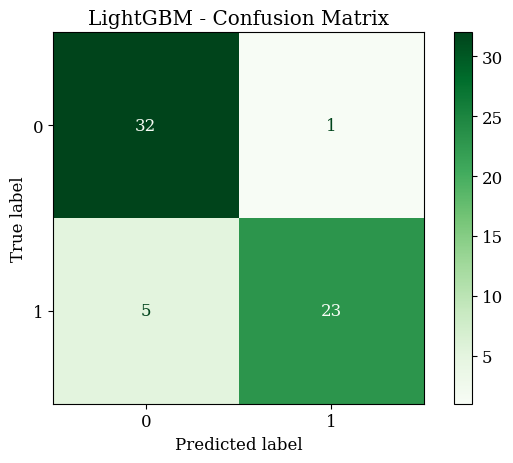

In [ ]:
# Compute confusion matrix for best model

cm = confusion_matrix(y_test, y_pred_lgb)
ConfusionMatrixDisplay(cm, display_labels=lgb_model.classes_).plot(cmap='Greens')
plt.title("LightGBM - Confusion Matrix")
plt.tight_layout()
plt.show()


#Explainable AI (XAI)

### **LIME (Local Interpretable Model-Agnostic Explanations)**






In [ ]:
# Initialize explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train_scaled),
    feature_names=x_train.columns,
    class_names= list(lgb_model.classes_),  # or use list(model.classes_) if applicable
    mode='classification'
)

# Explain one sample (you can change index)
sample_index = 30      # We can change the index & it will apply for that data
exp = explainer.explain_instance(
    data_row=x_test.iloc[sample_index],
    predict_fn=lgb_model.predict_proba
)

# Show explanation
exp.show_in_notebook(show_table=True)


### **SHAP (SHapley Additive exPlanations)**


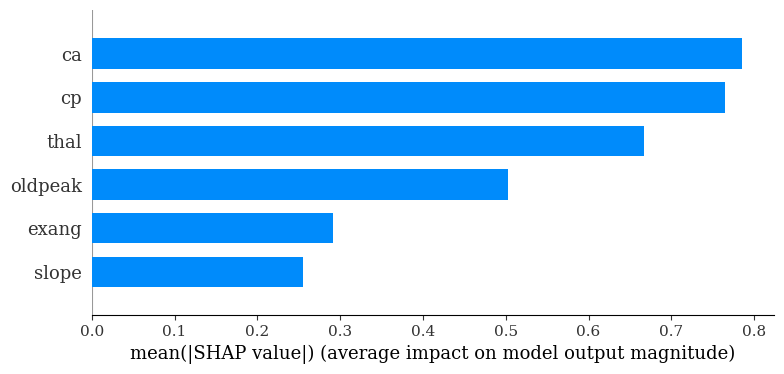

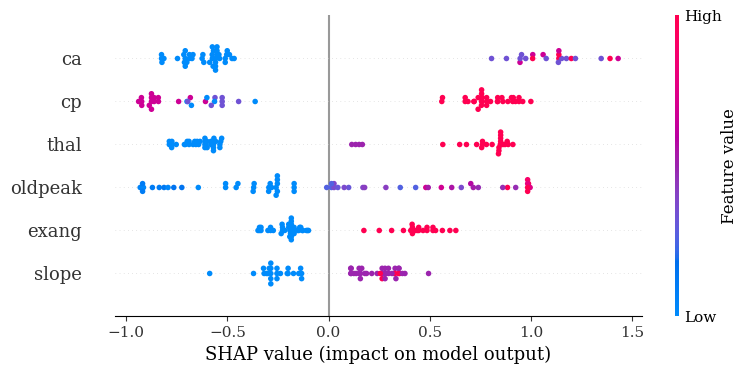

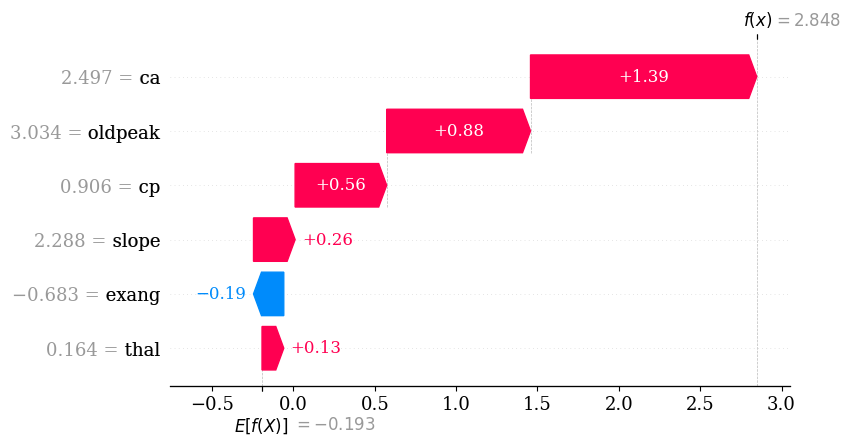

In [ ]:
# Giving x_test_scaled headings
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)
display(x_test_scaled_df.head())

# Initialize SHAP explainer
explainer = shap.Explainer(lgb_model, x_train_scaled)
shap_values = explainer(x_test_scaled_df)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, x_test_scaled_df, plot_type="bar")   # Didn't use x_test_scaled because it don't have heading(feature names)

# Detailed summary (beeswarm)
shap.summary_plot(shap_values, x_test_scaled_df)

# Explain a single instance
shap.plots.waterfall(shap_values[10])  # We can change the index & it will apply for that data